In this notebook, a logistic regression model is used to predict the probability of mortality for Sepsis patients. The model uses a single feature (SOFA) score for the patient. 

The underlying generative process of the data is assumed as following:
1. Nature chooses some $\theta$ which parameterizes the probability of mortality rates for individual SOFA scores ($X$)
2. Of the total number of patients $N_i$ with a particular SOFA score, the number of patient survival $K$ (r.v), follows a binomial distribution. $$K \sim Bin(N_i,p_{\theta}(x_i))$$ where $x_i$ refers to a SOFA score
3. The likelihood function is $$P(Y|X,\theta) = \prod_{i=1}^M {N_i \choose K_i}p_{\theta}(y_i|x_i)^{K_i}(1-p_{\theta}(y_i|x_i))^{N_i-K_i}$$

Where $N_i$ represents the total number of patients with a sofa score $x_i$ and $K_i$ represents the observed number of survival out of $N_i$ patients, $M$ represents the range of SOFA scores of patients

The form of $p_{\theta}(y_i|x_i)$ is the logistic function
where $$p_{\theta}(y_i|x_i) = \sigma(\theta_0 + \theta_1 x_1)$$
and $x_1$ represents the SOFA score

We further assume a Gaussian prior over the parameters $\theta_0,\theta_1$. This means that computing the posterior is an intractable operation. MCMC sampling is used to sample from the posterior distribution


In [1]:
# Bayesian inference problem for probability of survival for Sepsis patients
# look at SOFA scores to determine uncertainty
# Maximum SOFA score reached during trajectory and whether there was death or not
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import math

In [2]:
data = pd.read_csv("../data/mimicdata_MK.csv")

In [3]:
# y = a(1 - r)^x
# a = 1 and let r be unknown
# x = max. SOFA score in a trjectory
curr_sofa = -1
curr_mort = -1
dct = {}
# visualize data likelihood
for i in range(len(data) - 1):
    curr_state = data.iloc[i]
    next_state = data.iloc[i+1]
    
    sofa = curr_state['SOFA']
    mort = curr_state['died_in_hosp']
    icu_curr = curr_state['icustayid']
    icu_next = next_state['icustayid']
    
    if (sofa > curr_sofa):
        curr_sofa = sofa
        curr_mort = mort
        
    if (icu_curr != icu_next):
        # add statistics. (total, mortality)
        if curr_sofa not in dct:
            dct[curr_sofa] = (0,0)
        #update number
        total_count = dct[curr_sofa][0]
        total_mort = dct[curr_sofa][1]
        
        if (curr_mort):
            total_mort += 1
            
        update = (total_count + 1, total_mort)
        dct[curr_sofa] = update
        
        curr_sofa = -1
        curr_mort = -1

if curr_sofa not in dct:
    dct[curr_sofa] = (0,0)    
total_count = dct[curr_sofa][0]
total_mort = dct[curr_sofa][1]
total_mort = dct[curr_sofa][1]
if (curr_mort):
    total_mort += 1
            
update = (total_count + 1, total_mort)
dct[curr_sofa] = update




<BarContainer object of 24 artists>

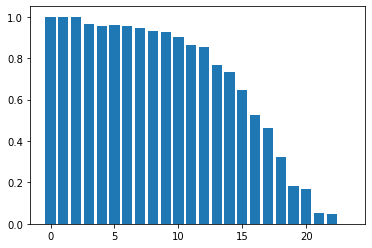

In [4]:
# plot data likelihood
x = [i for i in range(24)]
y = []
for key in sorted(dct.keys()):
    count, mort = dct[key]
    survive = 1 - (mort / count)
    y.append(survive)
plt.bar(x,y)

In [5]:
# calculate logistic likelihood
def logistic_likelihood(x, alpha, beta):
    return (1 / (1 + np.exp(beta*x + alpha)))

# returns the log factorial
def nCr(n,r):
    lgamma = math.lgamma
    return lgamma(n+1) - lgamma(r+1) - lgamma(n+1-r)
    #return f(n) / f(r) / f(n-r)

def log_likelihood(dct, alpha, beta):
    log_likelihood = 0
    for key in sorted(dct.keys()):
        count, mort = dct[key]
        survival = count - mort
        p = logistic_likelihood(key , alpha, beta)
        # convert to binomial likelihood
        # (p)^y(1-p)^(1-y)
        # log (nCr) + r log p + (count - r) log (1 - p)
        log_likelihood += nCr(count, survival) + (survival * np.log(p)) + mort * np.log(1 - p)
    return log_likelihood

In [6]:
# logistic regression model
# p(survive) = 1/(1+ e^(B(sofa) + a))
cov = [[1,0], [0,1]] # for sampling from symmetric multivariate normal
mean = [0,0]
#alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
#beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)

#initialize x(0). Sample from the prior distribution of alpha and beta
#alpha = np.random.normal()
x_init = np.random.multivariate_normal(mean, cov) # x_init = [alpha, beta]
max_iters = 100000
cov_q = [[0.05, 0], [0, 0.05]]
x_hist = []
for i in range(max_iters):
    x_prop = x_init + np.random.multivariate_normal(mean, cov_q)
    
    alpha_prop = x_prop[0]
    beta_prop = x_prop[1]
    
    alpha_prev = x_init[0]
    beta_prev = x_init[1]
    
    
    prior_alpha_prop = scipy.stats.norm(0, 1).pdf(alpha_prop)
    prior_beta_prop = scipy.stats.norm(0, 1).pdf(beta_prop)
    
    prior_alpha_prev = scipy.stats.norm(0, 1).pdf(alpha_prev)
    prior_beta_prev = scipy.stats.norm(0, 1).pdf(beta_prev)
    
    likelihood_prev = log_likelihood(dct, alpha_prev, beta_prev)
    likelihood_prop = log_likelihood(dct, alpha_prop, beta_prop)
    
    #ratio = (likelihood_prop * prior_alpha_prop * prior_beta_prop) / (likelihood_prev * prior_alpha_prev * prior_beta_prev)
    
    accept_log_prob = min(0, likelihood_prop - likelihood_prev)
    #print(accept_prob)
    
    rand = np.log(np.random.uniform(0.0, 1.0))
    
    if accept_log_prob > rand:
        x_init = x_prop
    
    # store proposals
    x_hist.append(x_init) 

(array([  4.89484975,   5.17191671,   0.        ,   0.        ,
          2.73988445,   8.06572725,   3.72501144,  29.70773588,
         30.75443331,  41.96025285,  13.82256312,  47.07059913,
        106.33214479,  49.77969836,  33.61745863,  29.15360194,
         30.10794372,  36.41891352,  21.08787469,  44.82327817,
         21.42651209,  21.98064603,   6.40332545,  15.30025361,
          2.30889139,   0.        ,   3.75579666,   0.        ,
          1.50847571,   3.78658188]),
 array([0.29071395, 0.29233811, 0.29396226, 0.29558642, 0.29721057,
        0.29883473, 0.30045889, 0.30208304, 0.3037072 , 0.30533136,
        0.30695551, 0.30857967, 0.31020382, 0.31182798, 0.31345214,
        0.31507629, 0.31670045, 0.3183246 , 0.31994876, 0.32157292,
        0.32319707, 0.32482123, 0.32644538, 0.32806954, 0.3296937 ,
        0.33131785, 0.33294201, 0.33456616, 0.33619032, 0.33781448,
        0.33943863]),
 [<matplotlib.patches.Polygon at 0x7f8cb7decf60>])

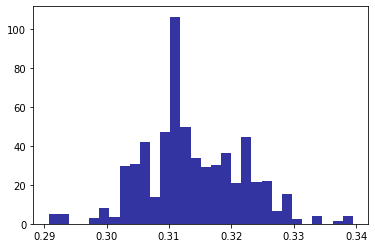

In [7]:
alpha_samples = list(map(lambda x: x[0], x_hist))[80000:]
beta_samples = list(map(lambda x: x[1], x_hist))[80000:]

plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)

(array([0.69078684, 0.13815737, 0.        , 0.74435807, 0.86277867,
        0.83458329, 1.85807563, 1.46615983, 0.23120213, 1.84397794,
        4.40411858, 3.62874559, 0.91916943, 2.78288415, 4.35336689,
        3.57517436, 2.93795874, 7.82985742, 3.94171432, 3.48494914,
        1.61277582, 4.10524753, 1.98777439, 0.20864582, 0.46804333,
        0.55826855, 0.        , 0.        , 0.        , 0.92198897]),
 array([-5.54026796, -5.52253456, -5.50480116, -5.48706776, -5.46933436,
        -5.45160095, -5.43386755, -5.41613415, -5.39840075, -5.38066735,
        -5.36293395, -5.34520055, -5.32746715, -5.30973375, -5.29200035,
        -5.27426695, -5.25653355, -5.23880014, -5.22106674, -5.20333334,
        -5.18559994, -5.16786654, -5.15013314, -5.13239974, -5.11466634,
        -5.09693294, -5.07919954, -5.06146614, -5.04373274, -5.02599933,
        -5.00826593]),
 [<matplotlib.patches.Polygon at 0x7f8cb7f0fd68>])

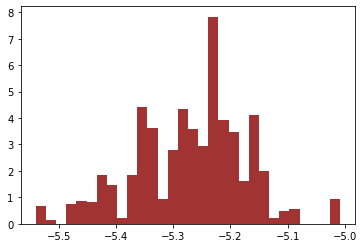

In [8]:
plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True)


In [9]:
alpha_est = np.mean(alpha_samples)
beta_est = np.mean(beta_samples)

<BarContainer object of 24 artists>

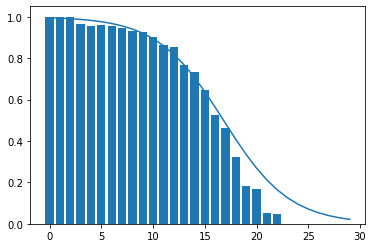

In [10]:
Y = [logistic_likelihood(i, alpha_est, beta_est) for i in range(30)]
plt.plot(Y)
plt.bar(x,y)

The probability of survival, given a new $x^*$ value is given by the equation $$p(y^*|x^*, X) = \int p(y^*|x^*,\theta)p(\theta | X)$$
where $p(\theta|X)$ is the posterior over weights and $p(y^*|x^*,\theta)$ is the probability distribution of patient survival/death given a new SOFA score $x^*$ and parameter $\theta$, corresponding to the logistic regression model

We can approximate the whole posterior predictive over the range of SOFA scores by sampling. $$E_{\theta \sim p(\theta|X)}[p(y^*|x^*,\theta)]$$


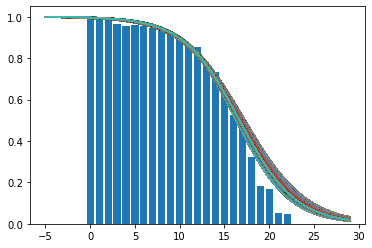

In [15]:
tot_samples = len(alpha_samples)
plt.bar(x,y)
for i in range(tot_samples):
    alpha = alpha_samples[i]
    beta = beta_samples[i]
    
    Y = [logistic_likelihood(i, alpha, beta) for i in range(-5,30)]
    plt.plot(np.arange(-5,30), Y)

plt.show()

The model gives higher uncertainty over regions in which SOFA score > 15. This could be due to the l